Das hier ist (hoffentlich) nun eine funktionstüchtige Version des Shor Algorithmus, die die U_a Gatter für allgemeine N implementiert. Für das Beispiel N = 15 werden exakt die gleichen Ergebnisse berechnet, wie aus dem Qiskit Beispiel welche die sonderform exklusiv für N = 15 des Shors umsetzt.
Die Umsetzung benötigt 4n+2 Qubits anstatt wie im Paper von Stêphane Beauregard 2n+3. Um diese Optimierung zu erreichen, muss lediglich die Messung der Ergebnisse von einem parallelen Vorgang in eine sequenzielle Messung abgeändert werden. Dadurch wird das obere/control Register, welches zu Begin des Shor Algorithmuses mit 2n vielen Hadamars versehen wird, auf ein einzelnes Qubit reduziert.

In [29]:
from qiskit import qiskit
from numpy import pi
from myQFT import myQFT
from binToDez import binToDez, dezToBin, mod_exp
from gcd import gcd
import math
from fractions import Fraction
from random import randint
import datetime;
from qiskit.visualization import plot_histogram

def unitary_operator_c(theta):
    return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(1)

def apply_unitary_operator(quantum_circuit, theta, control, target, exponent):
    #Rechne theta * exponent da schneller als exponent-Fache anwendung von U
    quantum_circuit.append(unitary_operator_c(theta/(2**exponent)),[control, target])
def QFT_Gate(amount_qubits, inverse = False, swaps = False, MSB_first = True):
    quantum_circuit = qiskit.QuantumCircuit(amount_qubits)
    if not MSB_first:
        measurement_qubits = list(reversed(range(amount_qubits)))
    else: 
        measurement_qubits = range(amount_qubits)
    if not inverse:
        index = 0
        for target in measurement_qubits:
            #quantum_circuit.barrier()
            exponent = 2
            quantum_circuit.h(target)
            for control in measurement_qubits[index + 1:]:
                apply_unitary_operator(quantum_circuit, 2 * pi, control, target, exponent)
                exponent+=1
            index+=1
        #quantum_circuit.barrier()
        if swaps:
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        quantum_circuit = quantum_circuit.to_gate()
        quantum_circuit.name = "  QFT"
        #quantum_circuit.barrier()
    else:
        if swaps:
            #quantum_circuit.barrier()
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        index = len(measurement_qubits) -1
        for target in reversed(measurement_qubits):
            #quantum_circuit.barrier()
            exponent = len(measurement_qubits[index + 1:]) + 1
            for control in reversed(measurement_qubits[index + 1:]):
                apply_unitary_operator(quantum_circuit, -2 * pi, control, target, exponent)
                exponent -= 1
            quantum_circuit.h(target)
            index-=1
        #quantum_circuit = quantum_circuit.to_gate()
        #quantum_circuit.name = "  iQFT"
        #quantum_circuit.barrier()
    return quantum_circuit

In [2]:
def P_Gate(theta: float, controls: int = 0) -> qiskit.circuit.library.standard_gates.PhaseGate:
    """Returns a Phase Gate with *controls* many controlled inputs
        A single Qubit Phase Gate looks like this:
        ( 1        0     )
        ( 0  e^(i*theta) )

    Parameters:
    theta: float
        determines the phase shift
    controls: int
        defines the amount of control bits. Default = 0

    Returns: Phase Gate with *controls* many controlled inputs
    """
    if controls > 0:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(controls)
    else:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta)))


In [3]:
def A_Gate(addend_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the complete Addition Circuit as an Gate for the quantum register + classial register Addition as descriped by Beauregard(Stêphane Beauregard, Circuit for Shor’s algorithm using 2n+3 qubits, https://arxiv.org/pdf/quant-ph/0205095.pdf) 
        Infact this is a combination of len(a_bin) many Phase Gates with added up theta's depending/controlled by the binary representation of the classically summand(a)
        The Gate operates on n+1 Qubits B contraining an n bit number to prevent overflow. So the input(before QFT) for the MSB of B should be (an extra) |0>

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.

    Returns: Complete classic + quantum Addition Circuite as an gate
    """
    A_Gate = qiskit.QuantumCircuit(len(addend_bin))
    theta_list = [0.0]*len(addend_bin)
    for target_bit in range(len(addend_bin)):
        exponent = 1
        for control_bit in reversed(range(target_bit+1)):
            if addend_bin[control_bit] == 1:
                theta_list[target_bit]+= 2*pi/(2**(exponent))
            exponent+=1
    for qubit_index in range(len(addend_bin)):
        A_Gate.append(P_Gate(theta_list[qubit_index]),[qubit_index])
    A_Gate = A_Gate.to_gate()
    A_Gate.name = "  Add(" + str (binToDez(addend_bin) )+ ")"
    return A_Gate

In [4]:
def S_Gate(subtrahend_bin: list[int]) -> qiskit.circuit.gate:
    S_Gate = A_Gate(subtrahend_bin).inverse()
    S_Gate.name = "  Sub(" + str (binToDez(subtrahend_bin) )+ ")"
    return S_Gate

![image](resources/add.jpg) <br />
Die obere Schaltung dient dazu um das Add Gatter zu testen. 
Dabei bedeutet $\Phi (b)$, dass das b vorher mithilfe der QFT in die Fourier Basis transformiert wurde <br />
![image](resources/add_case.img) <br />
Die vorherige Grafik zeigt was passiert wenn man das Add Gatter invertiert. Dabei kann man die invertierte Form des Gatters anhand des dicken dunklen Strichs an der linken Seite erkennen, die standart Varainte hat den Strich rechts.  

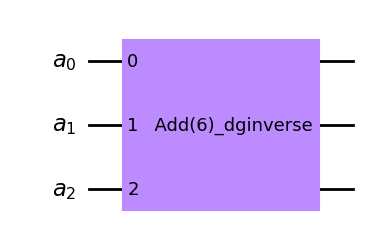

In [5]:
Register = qiskit.QuantumRegister(3, "a")
Schaltkreis = qiskit.QuantumCircuit(Register)
x = A_Gate([0,1,1]).inverse()
x.name = x.name + "inverse"
Schaltkreis.append(x,[0,1,2])
Schaltkreis.draw(output='mpl')

In [4]:
qc = qiskit.QuantumCircuit(5,5)
qc.x(0)
qc.x(3) #  b = 1 + 8 = 9
qc.barrier()
mes = [4,3,2,1,0]
myQFT(qc,mes) # b transform into fourier base 
qc.append(A_Gate([1,1,1,1,0]),[0,1,2,3,4]) # first list defines a, here: [1,1,1,1,0] = 1 + 2 + 4 + 8 = 15
myQFT(qc,mes,inverse = True)  # b back to "classical" base 
qc.barrier()
qc.measure(range(5),range(5)) # Messurment will be in usually bit order - MSB first.
qc.draw()


┌───┐ ░                                                                  »
q_0: ┤ X ├─░────────────────────────────────────────────────■─────────────────»
     └───┘ ░                                                │                 »
q_1: ──────░──────────────────────────────■─────────────────┼─────────■───────»
           ░                              │                 │         │       »
q_2: ──────░────────────────■─────────────┼────────■────────┼─────────┼───────»
     ┌───┐ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_3: ┤ X ├─░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     └───┘ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_4: ──────░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
           ░ └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                   ┌───┐┌─────────┐┌───┐»
«q_0: ──────■─────────────────■─────────────■───────┤ H ├┤0        ├┤ H ├»
«           │                 │       ┌───┐ │P(π/2) └───┘│         │└───┘»
«q_1: ──────┼────────■────────┼───────┤ H ├─■────────────┤1        ├─────»
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘              │         │     »
«q_2: ┤ H ├─┼────────■────────■──────────────────────────┤2 Add 15 ├─────»
«     └───┘ │P(π/8)                                      │         │     »
«q_3: ──────■────────────────────────────────────────────┤3        ├─────»
«                                                        │         │     »
«q_4: ───────────────────────────────────────────────────┤4        ├─────»
«                                                        └─────────┘     »
«c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                            »
«q_0: ─■──────────────■───────────────────■────────────────────────■─────────»
«      │P(-π/2) ┌───┐ │                   │                        │         »
«q_1: ─■────────┤ H ├─┼─────────■─────────┼──────────────■─────────┼─────────»
«               └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │         │         »
«q_2: ────────────────■─────────■─────────┼────────┤ H ├─┼─────────┼─────────»
«                                         │P(-π/8) └───┘ │P(-π/4)  │         »
«q_3: ────────────────────────────────────■──────────────■─────────┼─────────»
«                                                                  │P(-π/16) »
«q_4: ─────────────────────────────────────────────────────────────■─────────»
«                                                                            »
«c: 5/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                        ░ ┌─┐            
«q_0: ───────────────────────────────────────────────────░─┤M├────────────
«                                                        ░ └╥┘┌─┐         
«q_1: ───────────■───────────────────────────────────────░──╫─┤M├─────────
«                │                                       ░  ║ └╥┘┌─┐      
«q_2: ─■─────────┼──────────────■────────────────────────░──╫──╫─┤M├──────
«      │P(-π/2)  │        ┌───┐ │                        ░  ║  ║ └╥┘┌─┐   
«q_3: ─■─────────┼────────┤ H ├─┼─────────■──────────────░──╫──╫──╫─┤M├───
«                │P(-π/8) └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ───────────■──────────────■─────────■────────┤ H ├─░──╫──╫──╫──╫─┤M├
«                                                  └───┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                           0  

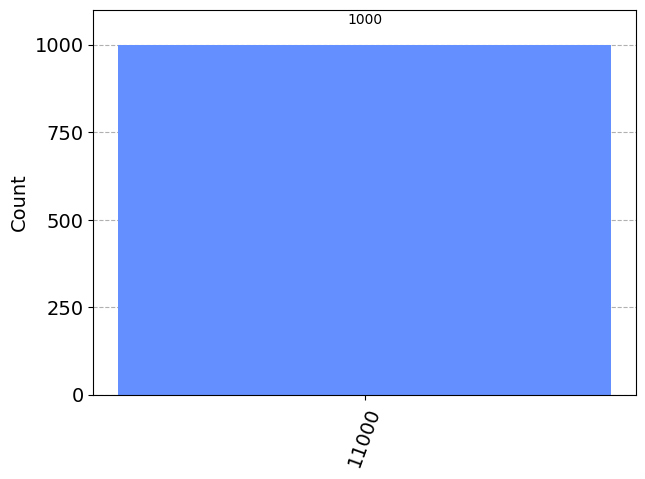

In [127]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

![image](resources/mod_add.img)

In [5]:
def modular_adder_gate(a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the modular adder gate. The Gate requiers 2 + len(a_bin) + 1 Qubit. The first two Qubits are both control Qubits, the last one is an anciallary Qubit which needs to be in state |0> in the beginning.

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.
    N_bin: list[int]
        Binary representation of the Moduland N / the Prime Factor. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.

    Returns:  modular adder gate
    """
    c_qbits = [0,1]
    b_qbits = list(range(2, len(a_bin)+2))
    cond_qbit = len(a_bin)+2
    m_a_g = qiskit.QuantumCircuit(2 + len(a_bin) + 1) # 2 Control Qubits + qubits for the input + ancillary qubit
    m_a_g.append(A_Gate(a_bin).control(2), c_qbits + b_qbits)
    m_a_g.append(S_Gate(N_bin),b_qbits)
    m_a_g.append(QFT_Gate(len(a_bin),inverse = True, MSB_first = False), b_qbits)
    m_a_g.cnot(b_qbits[-1],cond_qbit)
    m_a_g.append(QFT_Gate(len(a_bin),inverse = False, MSB_first = False), b_qbits)
    m_a_g.append(A_Gate(N_bin).control(1), [cond_qbit] + b_qbits)
    m_a_g.append(S_Gate(a_bin).control(2), c_qbits + b_qbits)
    m_a_g.append(QFT_Gate(len(a_bin),inverse = True, MSB_first = False), b_qbits)
    m_a_g.x(b_qbits[-1])
    m_a_g.cnot(b_qbits[-1],cond_qbit)
    m_a_g.x(b_qbits[-1])
    m_a_g.append(QFT_Gate(len(a_bin),inverse = False, MSB_first = False), b_qbits)
    m_a_g.append(A_Gate(a_bin).control(2), c_qbits + b_qbits)
    m_a_g = m_a_g.to_gate()
    m_a_g.name = "Add " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
    return m_a_g

In [6]:
qc = qiskit.QuantumCircuit(8,6)
qc.x(1)
qc.x(0)


qc.x(3)
qc.x(4)
qc.x(5)
qc.barrier()
mes = [6,5,4,3,2]
myQFT(qc,mes)
qc.append(modular_adder_gate([1,0,1,1,0],[1,1,1,1,0]),[0,1,2,3,4,5,6,7])
myQFT(qc,mes,inverse = True)
qc.barrier()
qc.measure(range(2,8),range(6))
qc.draw()

┌───┐ ░                                                                  »
q_0: ┤ X ├─░──────────────────────────────────────────────────────────────────»
     ├───┤ ░                                                                  »
q_1: ┤ X ├─░──────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                  »
q_2: ──────░────────────────────────────────────────────────■─────────────────»
     ┌───┐ ░                                                │                 »
q_3: ┤ X ├─░──────────────────────────────■─────────────────┼─────────■───────»
     ├───┤ ░                              │                 │         │       »
q_4: ┤ X ├─░────────────────■─────────────┼────────■────────┼─────────┼───────»
     ├───┤ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_5: ┤ X ├─░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     └───┘ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_6: ──────░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
           ░ └───┘                                                            »
q_7: ──────░──────────────────────────────────────────────────────────────────»
           ░                                                                  »
c: 6/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                        ┌────────────────┐»
«q_0: ───────────────────────────────────────────────────┤0               ├»
«                                                        │                │»
«q_1: ───────────────────────────────────────────────────┤1               ├»
«                                                   ┌───┐│                │»
«q_2: ──────■─────────────────■─────────────■───────┤ H ├┤2               ├»
«           │                 │       ┌───┐ │P(π/2) └───┘│                │»
«q_3: ──────┼────────■────────┼───────┤ H ├─■────────────┤3               ├»
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘              │  Add 13 Mod 15 │»
«q_4: ┤ H ├─┼────────■────────■──────────────────────────┤4               ├»
«     └───┘ │P(π/8)                                      │                │»
«q_5: ──────■────────────────────────────────────────────┤5               ├»
«                                                        │                │»
«q_6: ───────────────────────────────────────────────────┤6               ├»
«                                                        │                │»
«q_7: ───────────────────────────────────────────────────┤7               ├»
«                                                        └────────────────┘»
«c: 6/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────»
«                                                                      »
«q_1: ─────────────────────────────────────────────────────────────────»
«     ┌───┐                                                            »
«q_2: ┤ H ├─■──────────────■───────────────────■───────────────────────»
«     └───┘ │P(-π/2) ┌───┐ │                   │                       »
«q_3: ──────■────────┤ H ├─┼─────────■─────────┼──────────────■────────»
«                    └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │        »
«q_4: ─────────────────────■─────────■─────────┼────────┤ H ├─┼────────»
«                                              │P(-π/8) └───┘ │P(-π/4) »
«q_5: ─────────────────────────────────────────■──────────────■────────»
«                                                                      »
«q_6: ─────────────────────────────────────────────────────────────────»


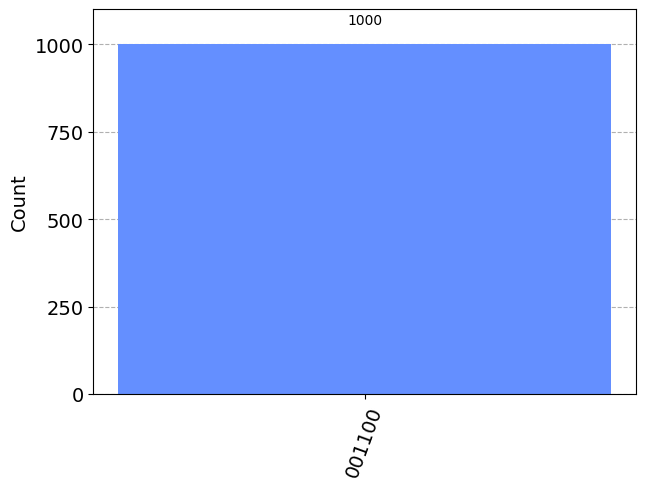

In [56]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

![image](resources/cmult_img)

In [6]:
def cmult_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the controlled multiplier gate. 
    The gate requiers 1 + x_bits_amount + len(a_bit) + 1
    The first Qubit is the controll qubit. The second x_bits_amount Qubits are for the Qubits of the (number) x. The a_bit should be the equal lenght of the b input qubits. The last Qubits is the ancillary Gate of the underlaying modular_adder_gates

    Parameters:
    x_bits_amount: int
       amount as an int of qubits for x
    a_bin: list[int]
        a_bin for the calculaton of the gate. a_bin should be as long as N_bin and as many binary bits as b qubits
    N_bin: list[int]
        N_bin for the calculaton of the gate. N_bin should be as long as a_bin
  
    Returns: controlled multiplier gate
    """
    a_dez = binToDez(a_bin)
    N_dez = binToDez(N_bin)
    c_qbit = [0]
    x_qbits =  list(range(1, x_bits_amount + 1))
    b_qbits = list(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))
    cond_qbit = [1 + x_bits_amount + len(a_bin)]
    cmult_gate = qiskit.QuantumCircuit(1 + x_bits_amount + len(a_bin) + 1)
    cmult_gate.append(QFT_Gate(len(b_qbits),inverse = False, MSB_first = False), b_qbits)
    for i in x_qbits:
        a_i = ((2**(i - 1)) *  a_dez) % N_dez
        a_i_bin = dezToBin(a_i, len(a_bin))
        cmult_gate.append(modular_adder_gate(a_i_bin, N_bin), c_qbit + [i] + b_qbits + cond_qbit )
    cmult_gate.append(QFT_Gate(len(b_qbits),inverse = True, MSB_first = False), b_qbits)
    cmult_gate = cmult_gate.to_gate()
    cmult_gate.name = "cmult " + str(a_dez) + " Mod " + str(N_dez)
    return cmult_gate

In [7]:
def inv_cmult_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the controlled multiplier gate. 
    The gate requiers 1 + x_bits_amount + len(a_bit) + 1
    The first Qubit is the controll qubit. The second x_bits_amount Qubits are for the Qubits of the (number) x. The a_bit should be the equal lenght of the b input qubits. The last Qubits is the ancillary Gate of the underlaying modular_adder_gates

    Parameters:
    x_bits_amount: int
       amount as an int of qubits for x
    a_bin: list[int]
        a_bin for the calculaton of the gate. a_bin should be as long as N_bin and as many binary bits as b qubits
    N_bin: list[int]
        N_bin for the calculaton of the gate. N_bin should be as long as a_bin
  
    Returns: controlled multiplier gate
    """
    inv_cmult_gate = cmult_gate(x_bits_amount,a_bin,N_bin).inverse()
    inv_cmult_gate.name = "inv cmult " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
    return inv_cmult_gate

In [58]:
qc = qiskit.QuantumCircuit(11,10)
#qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(4)

qc.x(5)
qc.x(6)
qc.x(7)
qc.x(8)
qc.append(cmult_gate(4,[1,1,1,0,0],[1,1,1,1,0]),range(11))


qc.measure(range(1,11),range(10))
qc.draw()

┌──────────────────┐                              
 q_0: ─────┤0                 ├──────────────────────────────
      ┌───┐│                  │┌─┐                           
 q_1: ┤ X ├┤1                 ├┤M├───────────────────────────
      ├───┤│                  │└╥┘┌─┐                        
 q_2: ┤ X ├┤2                 ├─╫─┤M├────────────────────────
      ├───┤│                  │ ║ └╥┘┌─┐                     
 q_3: ┤ X ├┤3                 ├─╫──╫─┤M├─────────────────────
      ├───┤│                  │ ║  ║ └╥┘┌─┐                  
 q_4: ┤ X ├┤4                 ├─╫──╫──╫─┤M├──────────────────
      ├───┤│                  │ ║  ║  ║ └╥┘┌─┐               
 q_5: ┤ X ├┤5  cmult 7 Mod 15 ├─╫──╫──╫──╫─┤M├───────────────
      ├───┤│                  │ ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ┤ X ├┤6                 ├─╫──╫──╫──╫──╫─┤M├────────────
      ├───┤│                  │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ┤ X ├┤7                 ├─╫──╫──╫──╫──╫──╫─┤M├─────────
      ├───┤│                  │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ┤ X ├┤8                 ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
      └───┘│                  │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ─────┤9                 ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
           │                  │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ─────┤10                ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           └──────────────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 10/══════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                0  1  2  3  4  5  6  7  8  9

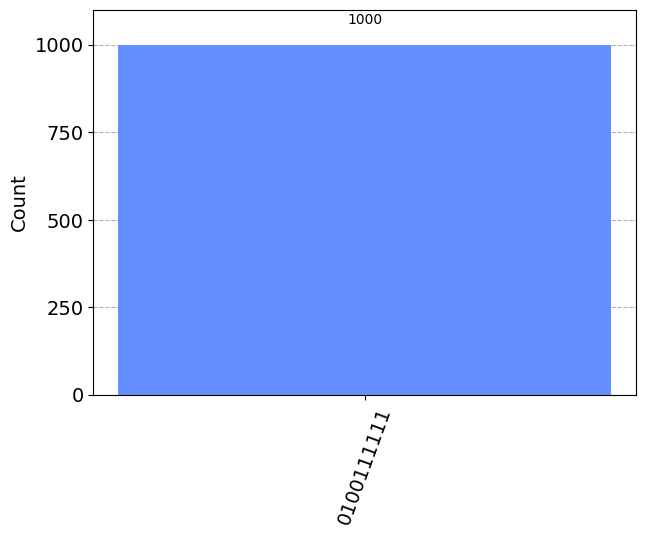

In [59]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

![image.png](resources/ua.img)

In [8]:
def U_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the U_a_gate. 

    Qubits:
    Number 0: Controll Qubit
    Number 1 to x_bits_amount: |x>
    Number (x_bits_amount+1) to (x_bits_amount+1+len(a_bin)): |0>
    Number Last: ancillary Gate of the underlaying controlled multiplier gates (|0>)

    Parameters:
    x_bits_amount: int
       amount as an int of qubits for x
    a_bin: list[int]
        a_bin for the calculaton of the gate. a_bin should be as long as N_bin and as many binary bits as b qubits
    N_bin: list[int]
        N_bin for the calculaton of the gate. N_bin should be as long as a_bin

    Returns:  controlled U-Gate
    """
    c_qbit = [0]
    x_qbits =  list(range(1, x_bits_amount + 1))
    b_qbits = list(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))
    cond_qbit = [1 + x_bits_amount + len(a_bin)]
    full_range = c_qbit + x_qbits + b_qbits + cond_qbit
    U_a_gate = qiskit.QuantumCircuit(len(full_range))
    U_a_gate.append(cmult_gate(x_bits_amount,a_bin ,N_bin), full_range)
    for i in (range(x_bits_amount)):
        U_a_gate.cswap(c_qbit,x_qbits[i],b_qbits[i])
    a_inv_bin = dezToBin(gcd(binToDez(a_bin),binToDez(N_bin)),len(a_bin))
    U_a_gate.append(inv_cmult_gate(x_bits_amount,a_inv_bin ,N_bin), full_range)
    U_a_gate = U_a_gate.to_gate()
    U_a_gate.name = "  U_" + str(binToDez(a_bin))
    return U_a_gate

In [17]:
qc = qiskit.QuantumCircuit(11,10)
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(4)
qc.append(U_a_gate(4,[1,0,1,1,0],[1,1,1,1,0]),range(11))
qc.measure(range(1,11),range(10))

qc.draw()

┌───┐┌────────┐                              
 q_0: ┤ X ├┤0       ├──────────────────────────────
      ├───┤│        │┌─┐                           
 q_1: ┤ X ├┤1       ├┤M├───────────────────────────
      ├───┤│        │└╥┘┌─┐                        
 q_2: ┤ X ├┤2       ├─╫─┤M├────────────────────────
      └───┘│        │ ║ └╥┘┌─┐                     
 q_3: ─────┤3       ├─╫──╫─┤M├─────────────────────
      ┌───┐│        │ ║  ║ └╥┘┌─┐                  
 q_4: ┤ X ├┤4       ├─╫──╫──╫─┤M├──────────────────
      └───┘│        │ ║  ║  ║ └╥┘┌─┐               
 q_5: ─────┤5  U_13 ├─╫──╫──╫──╫─┤M├───────────────
           │        │ ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ─────┤6       ├─╫──╫──╫──╫──╫─┤M├────────────
           │        │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ─────┤7       ├─╫──╫──╫──╫──╫──╫─┤M├─────────
           │        │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ─────┤8       ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
           │        │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ─────┤9       ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
           │        │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ─────┤10      ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           └────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 10/════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                      0  1  2  3  4  5  6  7  8  9

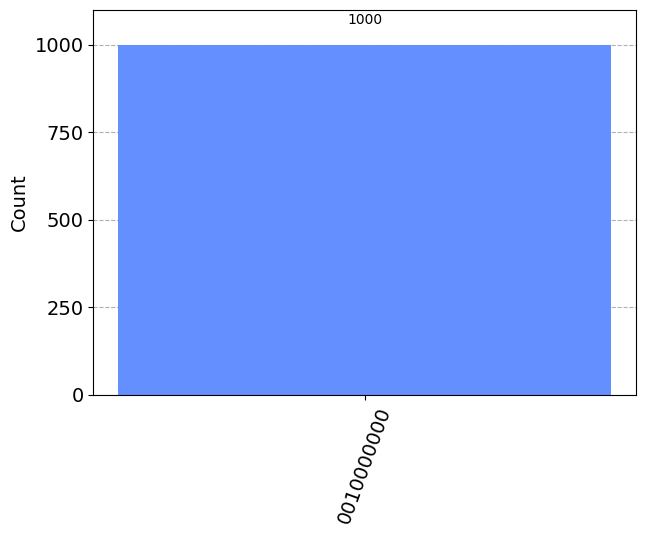

In [18]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)


In [63]:
a = 7
N = 351
n = 9
N_COUNT = 18
qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
for h in range(N_COUNT):
    qc.h(h)
qc.x(N_COUNT)
for control in range(N_COUNT):
    qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
myQFT(qc,list(reversed(range(0,n*2))),inverse = True,swaps = True)
qc.measure(range(N_COUNT),range(N_COUNT))
#qc.draw()

In [12]:
print(dict(qc.count_ops()))

{'cp': 153, 'h': 36, 'measure': 18, 'swap': 9, 'U_295': 3, 'U_328': 3, 'U_178': 3, 'U_94': 3, 'U_61': 2, 'U_211': 2, 'x': 1, 'U_7': 1, 'U_49': 1}


In [99]:
a = Shor_sequential(23,51)


In [9]:
def binary_to_decimal_in_dict(input_dict):
    output_dict = {}
    for binary_str, value in input_dict.items():
        decimal_number = int(binary_str, 2)
        output_dict[decimal_number] = value
    return output_dict

def binary_to_decimal_in_dict_print(input_dict,k , N):
    output_dict = {}
    for binary_str, value in input_dict.items():
        decimal_number = int(binary_str, 2)
        output_dict[decimal_number] = [value,(Fraction(decimal_number/2**k).limit_denominator(N)).denominator]
    return {k: v for k, v in sorted(output_dict.items())}
#plot_histogram(binary_to_decimal_in_dict(a),figsize =(22,5))

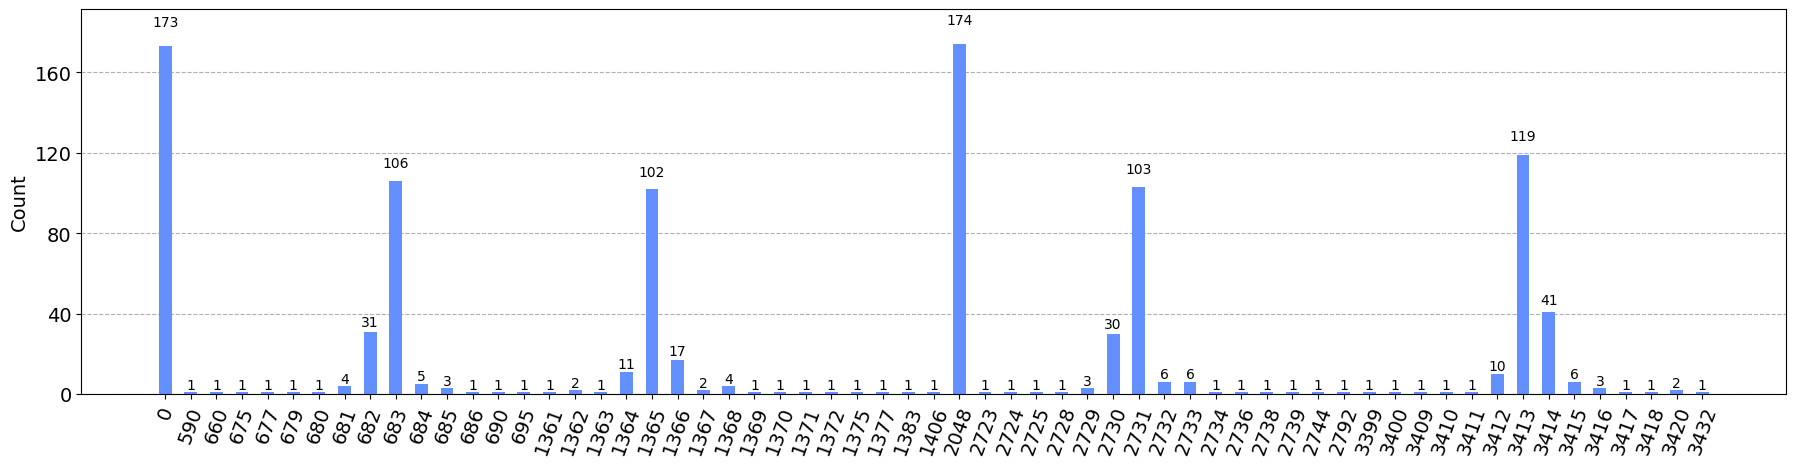

In [21]:
f = Shor_sequential(31,57)
plot_histogram(binary_to_decimal_in_dict(f),figsize =(22,5))

In [86]:
d = Shor_sequential(13,57,650)

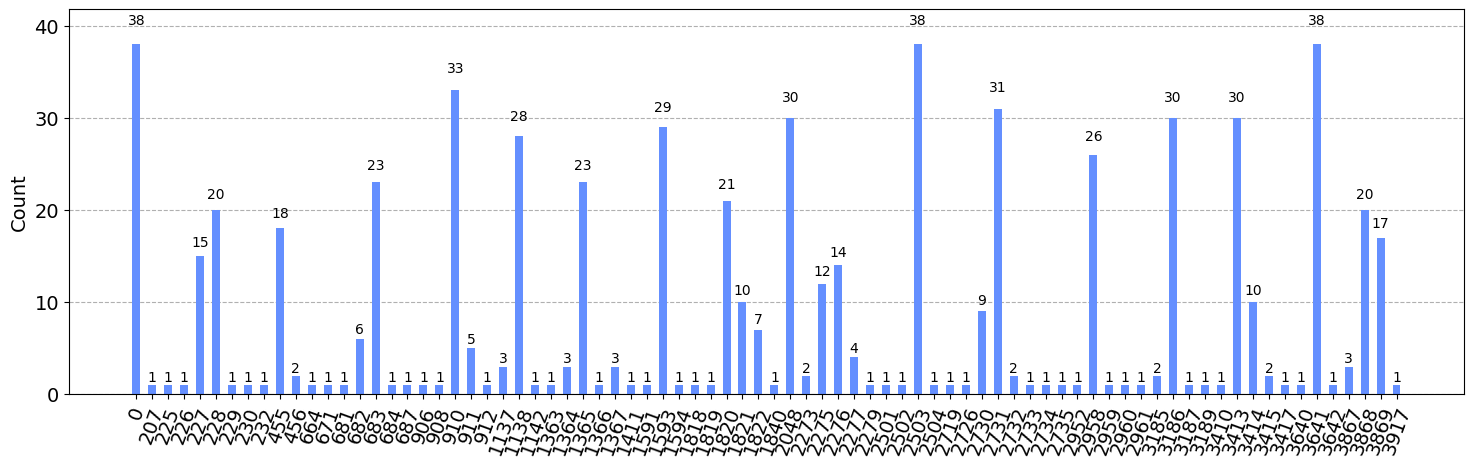

In [93]:

plot_histogram(binary_to_decimal_in_dict(d),figsize =(18,5))

In [25]:
N = 57
numb = 0
all = 0
l = []
for key,val in f.items():
    dec = int(key, 2)
    frac = Fraction(dec/(2**(2*N.bit_length()))).limit_denominator(57)
    if frac.denominator == 6:
        numb = numb + val
    all = all + val
    l.append((dec, frac))
for i in sorted(l):
    print(i)
print(numb)
print(all)

(0, Fraction(0, 1))
(590, Fraction(1, 7))
(660, Fraction(5, 31))
(675, Fraction(9, 55))
(677, Fraction(1, 6))
(679, Fraction(1, 6))
(680, Fraction(1, 6))
(681, Fraction(1, 6))
(682, Fraction(1, 6))
(683, Fraction(1, 6))
(684, Fraction(1, 6))
(685, Fraction(1, 6))
(686, Fraction(1, 6))
(690, Fraction(9, 53))
(695, Fraction(9, 53))
(1361, Fraction(1, 3))
(1362, Fraction(1, 3))
(1363, Fraction(1, 3))
(1364, Fraction(1, 3))
(1365, Fraction(1, 3))
(1366, Fraction(1, 3))
(1367, Fraction(1, 3))
(1368, Fraction(1, 3))
(1369, Fraction(1, 3))
(1370, Fraction(1, 3))
(1371, Fraction(1, 3))
(1372, Fraction(1, 3))
(1375, Fraction(1, 3))
(1377, Fraction(1, 3))
(1383, Fraction(19, 56))
(1406, Fraction(12, 35))
(2048, Fraction(1, 2))
(2723, Fraction(2, 3))
(2724, Fraction(2, 3))
(2725, Fraction(2, 3))
(2728, Fraction(2, 3))
(2729, Fraction(2, 3))
(2730, Fraction(2, 3))
(2731, Fraction(2, 3))
(2732, Fraction(2, 3))
(2733, Fraction(2, 3))
(2734, Fraction(2, 3))
(2736, Fraction(2, 3))
(2738, Fraction(2, 3

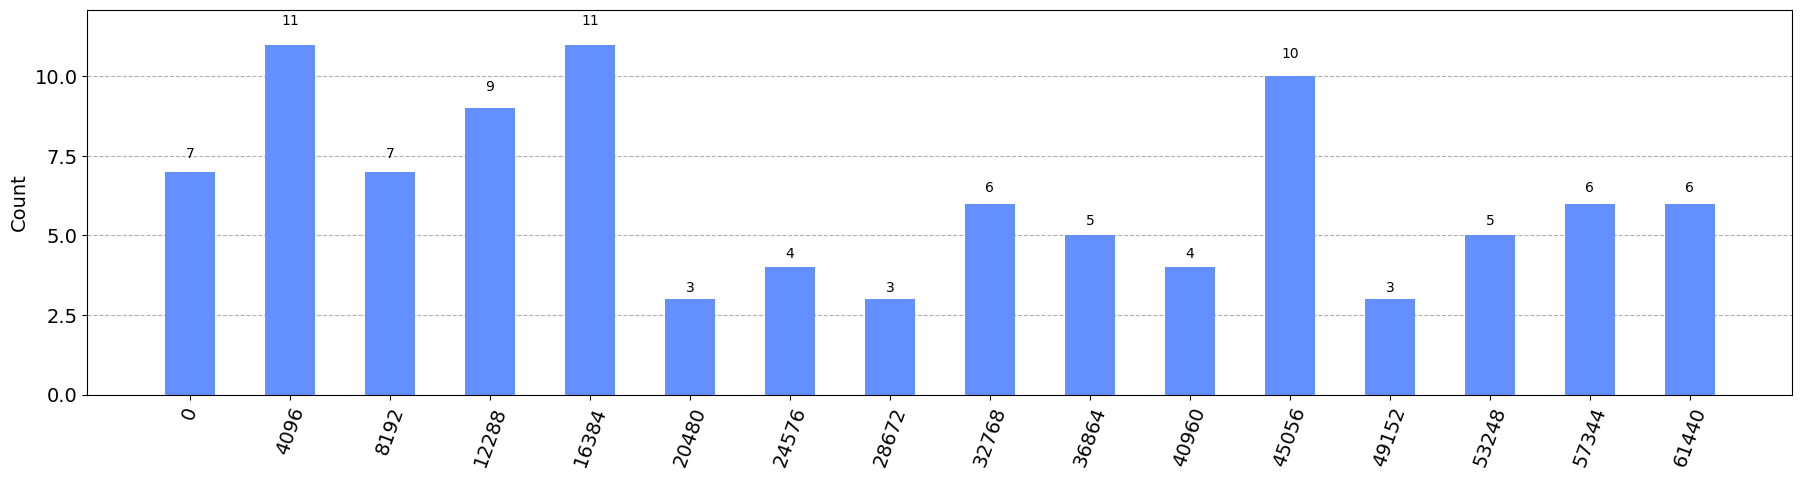

In [26]:
f = Shor_sequential(31,221,100)
plot_histogram(binary_to_decimal_in_dict(f),figsize =(22,5))

In [28]:
N = 221
numb = 0
all = 0
l = []
for key,val in f.items():
    dec = int(key, 2)
    frac = Fraction(dec/(2**(2*N.bit_length()))).limit_denominator(221)
    if frac.denominator == 16:
        numb = numb + val
    all = all + val
    l.append((dec, frac))
for i in sorted(l):
    print(i)
print(numb)
print(all)

(0, Fraction(0, 1))
(4096, Fraction(1, 16))
(8192, Fraction(1, 8))
(12288, Fraction(3, 16))
(16384, Fraction(1, 4))
(20480, Fraction(5, 16))
(24576, Fraction(3, 8))
(28672, Fraction(7, 16))
(32768, Fraction(1, 2))
(36864, Fraction(9, 16))
(40960, Fraction(5, 8))
(45056, Fraction(11, 16))
(49152, Fraction(3, 4))
(53248, Fraction(13, 16))
(57344, Fraction(7, 8))
(61440, Fraction(15, 16))
52
100


In [ ]:
f = Shor_sequential(31,323,100)
plot_histogram(binary_to_decimal_in_dict(f),figsize =(22,5))

In [32]:
N = 253
numb = 0
all = 0
l = []
for key,val in f.items():
    dec = int(key, 2)
    frac = Fraction(dec/(2**(2*N.bit_length()))).limit_denominator(N)
    if frac.denominator == 55:
        numb = numb + val
    all = all + val
    l.append((dec, frac))
for i in sorted(l):
    print(i)
print(numb)
print(all)

(0, Fraction(0, 1))
(1191, Fraction(1, 55))
(1195, Fraction(4, 219))
(2383, Fraction(2, 55))
(3575, Fraction(3, 55))
(4765, Fraction(4, 55))
(4766, Fraction(4, 55))
(4767, Fraction(4, 55))
(5958, Fraction(1, 11))
(8341, Fraction(7, 55))
(9533, Fraction(8, 55))
(9538, Fraction(31, 213))
(10724, Fraction(9, 55))
(11916, Fraction(2, 11))
(13107, Fraction(1, 5))
(14299, Fraction(12, 55))
(15489, Fraction(13, 55))
(15490, Fraction(13, 55))
(17873, Fraction(3, 11))
(19065, Fraction(16, 55))
(20257, Fraction(17, 55))
(21448, Fraction(18, 55))
(22639, Fraction(19, 55))
(22640, Fraction(19, 55))
(23831, Fraction(4, 11))
(25023, Fraction(21, 55))
(26213, Fraction(2, 5))
(26214, Fraction(2, 5))
(26215, Fraction(2, 5))
(27406, Fraction(23, 55))
(28598, Fraction(24, 55))
(29789, Fraction(5, 11))
(30980, Fraction(26, 55))
(32172, Fraction(27, 55))
(33363, Fraction(28, 55))
(33364, Fraction(28, 55))
(35747, Fraction(6, 11))
(38130, Fraction(32, 55))
(39322, Fraction(3, 5))
(41705, Fraction(7, 11))
(4

In [10]:
def Shor(a: int, N: int,number_shots: int = 1200, backend: str = 'aer_simulator'):
    n = N.bit_length()
    c_qbits = range(2*n)
    ev_qbits = list(range(len(c_qbits),4*n+2))
    qc = qiskit.QuantumCircuit(4*n+2,len(c_qbits)) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
    for c_bit in c_qbits:
        qc.h(c_bit)
    qc.x(ev_qbits[0])
    for c_bit in c_qbits:
        qc.append(U_gate(n,dezToBin(mod_exp(a, 2**c_bit, N),n+1),dezToBin(N,n+1)),[c_bit] + ev_qbits)
    qc.append(QFT_Gate(len(c_qbits),inverse = True, MSB_first = False,swaps = True), c_qbits)
    qc.measure(c_qbits,c_qbits)
    simulator = qiskit.Aer.get_backend(backend)
    sim_result = qiskit.execute(qc, backend=simulator, shots=number_shots).result()
    return sim_result.get_counts(qc)

In [11]:
def calculate_primfactors_Shor(N, sequential = False):
    if N % 2 == 0:
        print("primfaktors: [" + str(2) +", " + str(N//2) + "]")
        return 0
    else:
        while True:
            a = randint(3, N)
            if math.gcd(a,N) != 1:
                print("primfaktors: [" + str(math.gcd(a,N)) +", " + str(N//math.gcd(a,N)) + "]")
                return 0
            else:
                n = math.ceil(math.log2(N))
                N_COUNT = 2*n
                if sequential:
                    counts_result = Shor_sequential(a,N,n,N_COUNT)
                    print("sequential")
                else:
                    counts_result = Shor(a,N,n,N_COUNT)
                peaks = []
                for count in counts_result.items():
                    if count[1] > 0: #Threshold
                        decimal = int(count[0], 2)
                        peaks.append([decimal, decimal/(2**N_COUNT)])
                print(peaks)
                print(str(a))
                #test 
                infofrac = []
                for peak in peaks:
                    infofrac.append(Fraction(peak[1]).limit_denominator(N))
                  ###  
                for peak in peaks:
                    frac = Fraction(peak[1]).limit_denominator(N)
                    if frac.denominator % 2 == 0 :
                        guesses = [math.gcd(a**(frac.denominator//2)-1, N), math.gcd(a**(frac.denominator//2)+1, N)]
                        if guesses[0] != 1 and guesses[0] != N:
                            print("primfaktors by Shor: [" + str(guesses[0]) +", " + str(N//guesses[0]) + "]")
                            print(infofrac)
                            return counts_result
                        elif guesses[1] != 1 and guesses[1] != N:
                            print("primfaktors by Shor: [" + str(guesses[1]) +", " + str(N//guesses[1]) + "]")
                            print(infofrac)
                            return counts_result
                print(infofrac)
                print("retry ")
                continue
    
    

In [12]:
def R_gate(index,qc,creg,controlling_qubit):
    if index == 0:
        qc.h(controlling_qubit)
    else:
        for i in list(reversed(range(index))):
            qc.p((-pi/(2**(i+1))),controlling_qubit).c_if(creg[index - (i+1)],1)
        qc.h(controlling_qubit)

In [13]:
def Shor_sequential(a: int, N: int,number_shots: int = 1000, backend: str = 'aer_simulator'):
    n = N.bit_length()
    c_qbits = range(2*n)
    controlling_qubit = qiskit.QuantumRegister(1, "c_qubit")
    qreg = qiskit.QuantumRegister(2*n+2, "qreg")
    creg = qiskit.ClassicalRegister(len(c_qbits), "creg")
    qc = qiskit.QuantumCircuit(controlling_qubit, qreg,creg) 
    qc.x(1)
    for control in c_qbits:
        qc.h(0)
        qc.append(U_gate(n,dezToBin(mod_exp(a, 2**(len(c_qbits) - control - 1), N),n+1),dezToBin(N,n+1)),[0] + list(range(1,2*n+3)))
        R_gate(control,qc,creg,controlling_qubit)
        qc.measure(controlling_qubit,creg[control])
        qc.x(0).c_if(creg[control],1)
    #return qc
    simulator = qiskit.Aer.get_backend(backend)
    sim_result = qiskit.execute(qc, backend=simulator, shots=number_shots).result()
    return sim_result.get_counts(qc)

In [68]:
qc = qiskit.QuantumCircuit(3)
myQFT(qc,list(reversed(range(0,3))),inverse = False,swaps = True)
qc.draw()

┌───┐   
q_0: ───────────────■─────────────■───────┤ H ├─X─
                    │       ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────■────────┼───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

In [69]:
qc = qiskit.QuantumCircuit(3)
myQFT(qc,list(reversed(range(0,3))),inverse = True,swaps = True)
qc.draw()

┌───┐                                        
q_0: ─X─┤ H ├─■──────────────■───────────────────────
      │ └───┘ │P(-π/2) ┌───┐ │                       
q_1: ─┼───────■────────┤ H ├─┼─────────■─────────────
      │                └───┘ │P(-π/4)  │P(-π/2) ┌───┐
q_2: ─X──────────────────────■─────────■────────┤ H ├
                                                └───┘

In [14]:
def Shor_sequential_test(a: int, N: int, k: int = -1,number_shots: int = 1, backend: str = 'aer_simulator'):
    n = N.bit_length()
    if k == -1:
        k = 2*n
    c_qbits = range(k)
    controlling_qubit = qiskit.QuantumRegister(1, "c_qubit")
    qreg = qiskit.QuantumRegister(2*n+2, "qreg")
    creg = qiskit.ClassicalRegister(len(c_qbits), "creg")
    qc = qiskit.QuantumCircuit(controlling_qubit, qreg,creg) 
    qc.x(1)
    for control in c_qbits:
        qc.h(0)
        qc.append(U_gate(n,dezToBin(mod_exp(a, 2**(len(c_qbits) - control - 1), N),n+1),dezToBin(N,n+1)),[0] + list(range(1,2*n+3)))
        R_gate(control,qc,creg,controlling_qubit)
        qc.measure(controlling_qubit,creg[control])
        qc.x(0).c_if(creg[control],1)
    #return qc
    simulator = qiskit.Aer.get_backend(backend)
    sim_result = qiskit.execute(qc, backend=simulator, shots=number_shots).result()
    return sim_result.get_counts(qc)
    
def calculate_primfactors_Shor_test(N, sequential = False):
    if N % 2 == 0:
        print("primfaktors: [" + str(2) +", " + str(N//2) + "]")
        return 0
    else:
        while True:
            a = 327#randint(3, N)
            if math.gcd(a,N) != 1:
                print("primfaktors: [" + str(math.gcd(a,N)) +", " + str(N//math.gcd(a,N)) + "]")
                return 0
            else:
                n = math.ceil(math.log2(N))
                N_COUNT = 2*n+1
                if sequential:
                    counts_result = Shor_sequential_test(a,N,n,N_COUNT)
                    print("sequential")
                else:
                    counts_result = Shor(a,N,n,N_COUNT)
                peaks = []
                for count in counts_result.items():
                    if count[1] > 0: #Threshold
                        decimal = int(count[0], 2)
                        peaks.append([decimal, decimal/(2**N_COUNT)])
                print(peaks)
                print(str(a))
                #test 
                infofrac = []
                for peak in peaks:
                    infofrac.append(Fraction(peak[1]).limit_denominator(N))
                  ###  
                for peak in peaks:
                    frac = Fraction(peak[1]).limit_denominator(N)
                    if frac.denominator % 2 == 0 :
                        guesses = [math.gcd(a**(frac.denominator//2)-1, N), math.gcd(a**(frac.denominator//2)+1, N)]
                        if guesses[0] != 1 and guesses[0] != N:
                            print("primfaktors by Shor: [" + str(guesses[0]) +", " + str(N//guesses[0]) + "]")
                            print(infofrac)
                            return counts_result
                        elif guesses[1] != 1 and guesses[1] != N:
                            print("primfaktors by Shor: [" + str(guesses[1]) +", " + str(N//guesses[1]) + "]")
                            print(infofrac)
                            return counts_result
                print(infofrac)
                print("retry ")
                continue

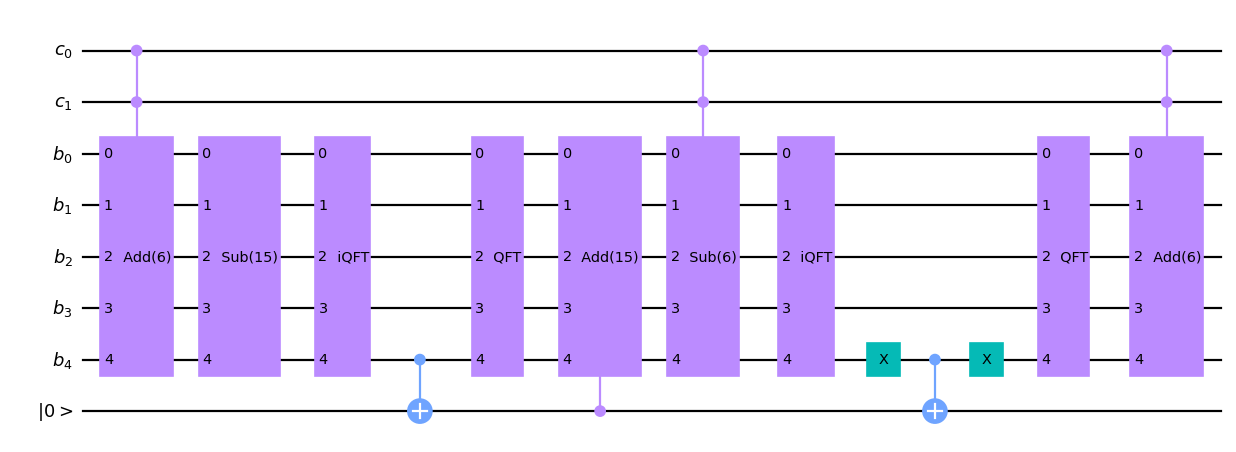

In [12]:

    """Returns the modular adder gate. The Gate requiers 2 + len(a_bin) + 1 Qubit. The first two Qubits are both control Qubits, the last one is an anciallary Qubit which needs to be in state |0> in the beginning.

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.
    N_bin: list[int]
        Binary representation of the Moduland N / the Prime Factor. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.

    Returns:  modular adder gate
    """
a_bin= [0,1,1,0,0]
N_bin= [1,1,1,1,0]
creg = qiskit.QuantumRegister(2, "c")
breg = qiskit.QuantumRegister(5, "b")
bereg = qiskit.QuantumRegister(1, "|0>")
c_qbits = [0,1]
b_qbits = list(range(2, len(a_bin)+2))
cond_qbit = len(a_bin)+2
modular_adder_gate = qiskit.QuantumCircuit(creg,breg, bereg) # 2 Control Qubits + qubits for the input + ancillary qubit
modular_adder_gate.append(A_Gate(a_bin).control(2), c_qbits + b_qbits)
modular_adder_gate.append(S_Gate(N_bin),b_qbits)
modular_adder_gate.append(QFT_Gate(len(a_bin),inverse = True, MSB_first = False), b_qbits)
modular_adder_gate.cnot(b_qbits[-1],cond_qbit)
modular_adder_gate.append(QFT_Gate(len(a_bin),inverse = False, MSB_first = False), b_qbits)
modular_adder_gate.append(A_Gate(N_bin).control(1), [cond_qbit] + b_qbits)
modular_adder_gate.append(S_Gate(a_bin).control(2), c_qbits + b_qbits)
modular_adder_gate.append(QFT_Gate(len(a_bin),inverse = True, MSB_first = False), b_qbits)
modular_adder_gate.x(b_qbits[-1])
modular_adder_gate.cnot(b_qbits[-1],cond_qbit)
modular_adder_gate.x(b_qbits[-1])
modular_adder_gate.append(QFT_Gate(len(a_bin),inverse = False, MSB_first = False), b_qbits)
modular_adder_gate.append(A_Gate(a_bin).control(2), c_qbits + b_qbits)
#modular_adder_gate = modular_adder_gate.to_gate()
#modular_adder_gate.name = " Add " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
modular_adder_gate.draw(output='mpl',fold  = 270,scale=0.8)

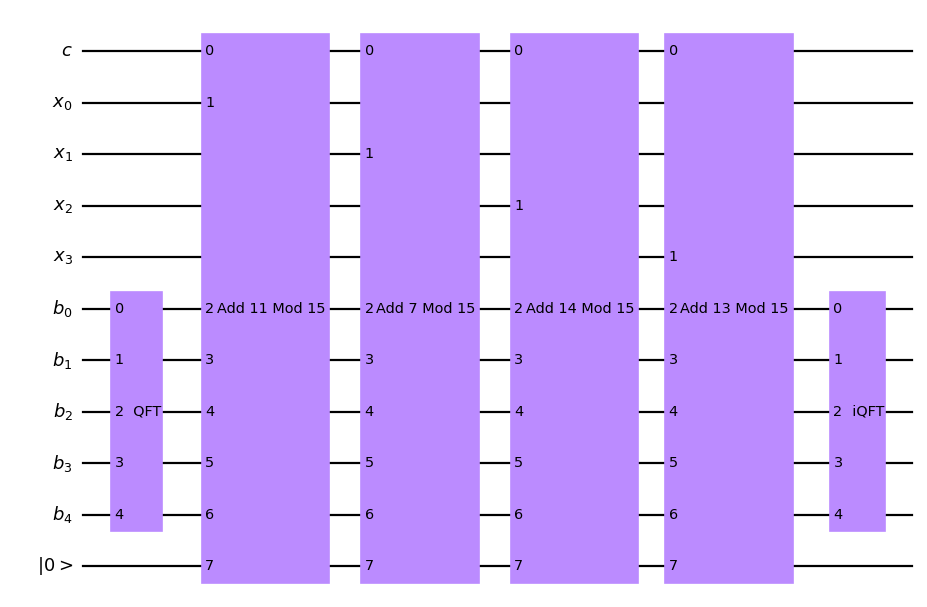

In [17]:
creg = qiskit.QuantumRegister(1, "c")
xreg = qiskit.QuantumRegister(4, "x")
breg = qiskit.QuantumRegister(5, "b")
bereg = qiskit.QuantumRegister(1, "|0>")
x_bits_amount = 4
a_bin = [1,1,0,1,0]
N_bin = [1,1,1,1,0]
a_dez = binToDez(a_bin)
N_dez = binToDez(N_bin)
c_qbit = [0]
x_qbits =  list(range(1, x_bits_amount + 1))
b_qbits = list(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))
cond_qbit = [1 + x_bits_amount + len(a_bin)]
cmult_gate = qiskit.QuantumCircuit(creg , xreg , breg , bereg)
cmult_gate.append(QFT_Gate(len(b_qbits),inverse = False, MSB_first = False), b_qbits)
for i in range(0, len(x_qbits)):
    a_i = ((2**(i)) *  a_dez) % N_dez
    a_i_bin = dezToBin(a_i, len(a_bin))
    cmult_gate.append(modular_adder_gate(a_i_bin, N_bin), c_qbit + [x_qbits[i]] + b_qbits + cond_qbit )
cmult_gate.append(QFT_Gate(len(b_qbits),inverse = True, MSB_first = False), b_qbits)
cmult_gate.draw(output='mpl',fold  = 270,scale=0.8)

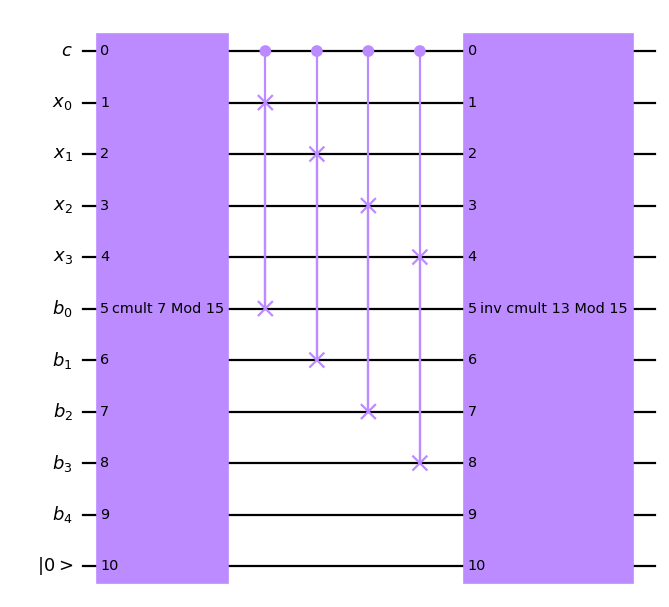

In [64]:
#def U_a_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:

creg = qiskit.QuantumRegister(1, "c")
xreg = qiskit.QuantumRegister(4, "x")
breg = qiskit.QuantumRegister(5, "b")
bereg = qiskit.QuantumRegister(1, "|0>")
x_bits_amount = 4
a_bin = [1,1,1,0,0]
N_bin = [1,1,1,1,0]

c_qbit = [0]
x_qbits =  list(range(1, x_bits_amount + 1))
b_qbits = list(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))
cond_qbit = [1 + x_bits_amount + len(a_bin)]
full_range = c_qbit + x_qbits + b_qbits + cond_qbit

U_a_gate = qiskit.QuantumCircuit(creg, xreg, breg, bereg)
U_a_gate.append(cmult_gate(x_bits_amount,a_bin ,N_bin), full_range)
for i in (range(x_bits_amount)):
    U_a_gate.cswap(c_qbit,x_qbits[i],b_qbits[i])
a_inv_bin = dezToBin(gcd(binToDez(a_bin),binToDez(N_bin)),len(a_bin))
U_a_gate.append(inv_cmult_gate(x_bits_amount,a_inv_bin ,N_bin), full_range)
U_a_gate.draw(output='mpl',fold  = 270,scale=0.8)

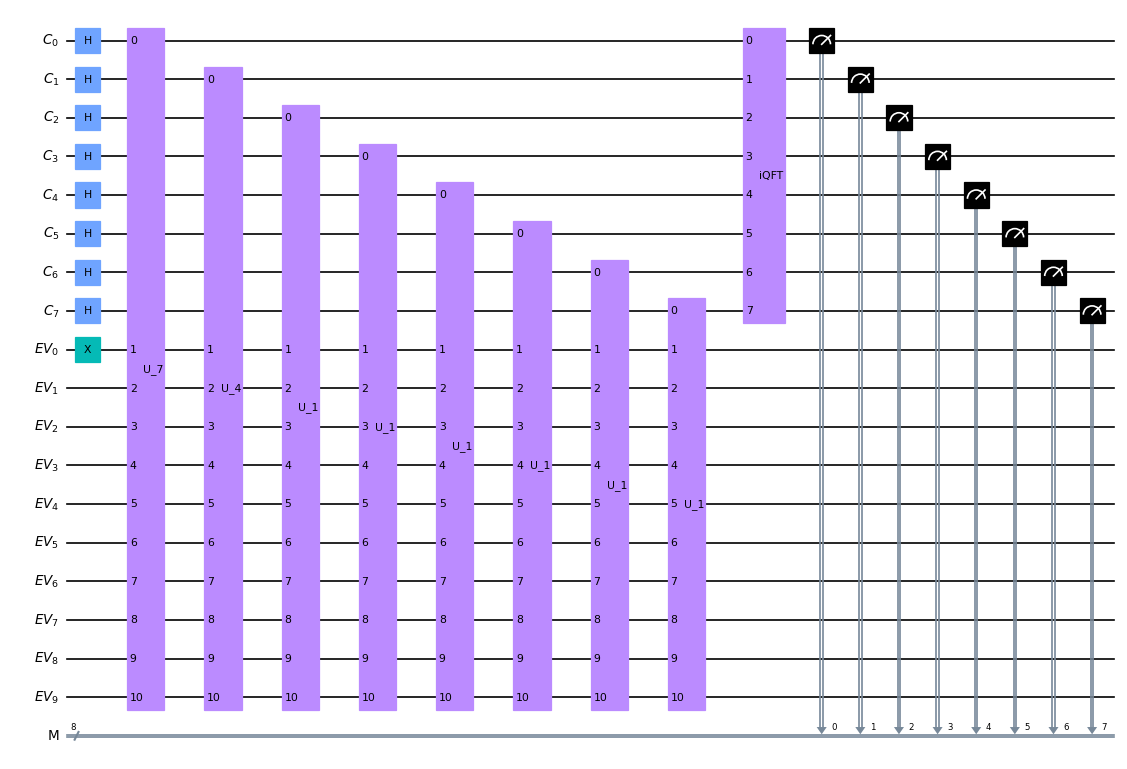

In [19]:
a=7
N=15
n = N.bit_length()
c_qbits = range(2*n)
ev_qbits = list(range(len(c_qbits),4*n+2))
creg = qiskit.QuantumRegister(len(c_qbits), "C")
xreg = qiskit.QuantumRegister(len(list(range(len(c_qbits),4*n+2))), "EV")
mreg = qiskit.ClassicalRegister(len(c_qbits), "M")
qc = qiskit.QuantumCircuit(creg,xreg,mreg) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
for c_bit in c_qbits:
    qc.h(c_bit)
qc.x(ev_qbits[0])
for c_bit in c_qbits:
    qc.append(U_gate(n,dezToBin(mod_exp(a, 2**c_bit, N),n+1),dezToBin(N,n+1)),[c_bit] + ev_qbits)
qc.append(QFT_Gate(len(c_qbits),inverse = True, MSB_first = False,swaps = True), c_qbits)
qc.measure(c_qbits,c_qbits)
qc.draw(output='mpl',fold  = 270,scale=0.6)


In [31]:
print(31**55 % 253)

1


In [156]:
for i in range(1,71):
    if (19**i%119 == 1):
        print(i)
        break
        

24


In [ ]:
for i in range(1,119):
    if (37**i%119 == 1):
        print(i)
        break

In [62]:
print(Shor_sequential_test(43,57,number_shots = 1))

{'001110001111': 1}


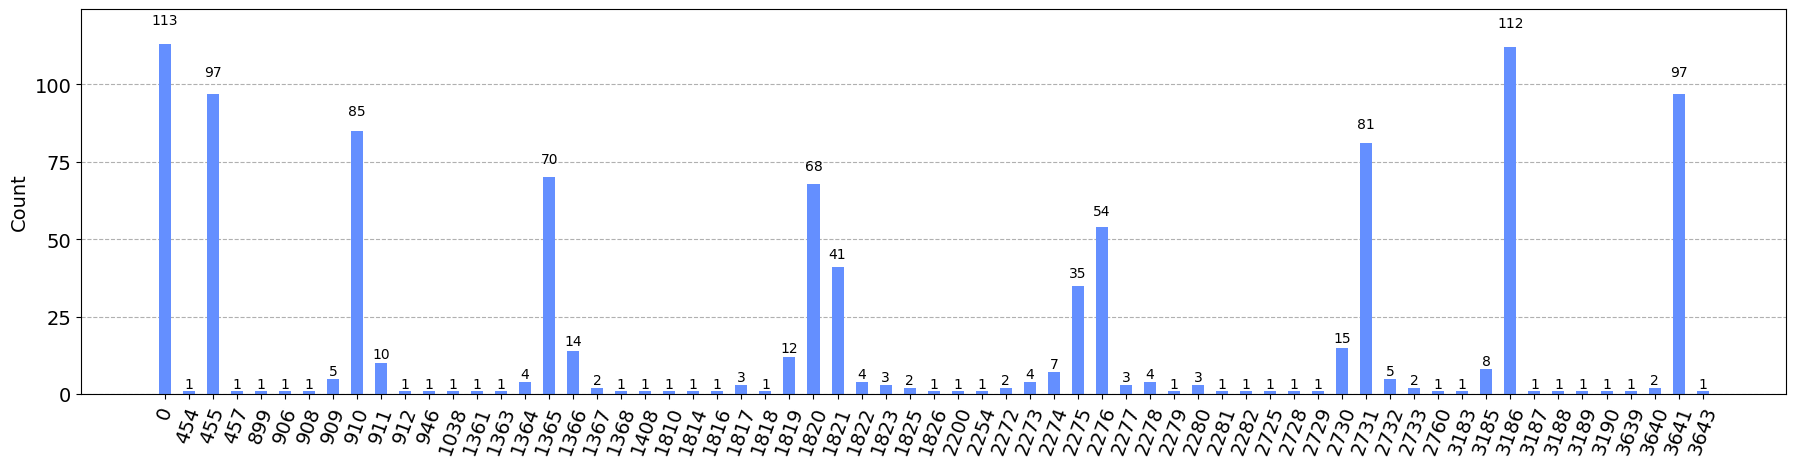

In [56]:
xx = Shor_sequential_test(43,57,number_shots = 1000)
plot_histogram(binary_to_decimal_in_dict(xx),figsize =(22,5))

In [ ]:
plot_histogram(binary_to_decimal_in_dict(yyy),figsize =(22,5))

In [41]:
print(binary_to_decimal_in_dict_print(yyy, 12, 52))

{0: [18, 1], 340: [2, 12], 341: [8, 12], 342: [2, 12], 668: [1, 49], 682: [4, 6], 683: [10, 6], 685: [1, 6], 1024: [15, 4], 1363: [1, 3], 1365: [14, 3], 1366: [3, 3], 1368: [1, 3], 1370: [1, 3], 1704: [1, 12], 1706: [3, 12], 1707: [14, 12], 2048: [21, 2], 2364: [1, 26], 2389: [6, 12], 2390: [1, 12], 2405: [1, 46], 2727: [1, 3], 2730: [1, 3], 2731: [16, 3], 2732: [2, 3], 3072: [12, 4], 3413: [13, 6], 3414: [2, 6], 3415: [1, 6], 3416: [1, 6], 3754: [3, 12], 3755: [17, 12], 3756: [2, 12]}


In [32]:
def kgV(a, b):
    return abs(a * b) // math.gcd(a, b)

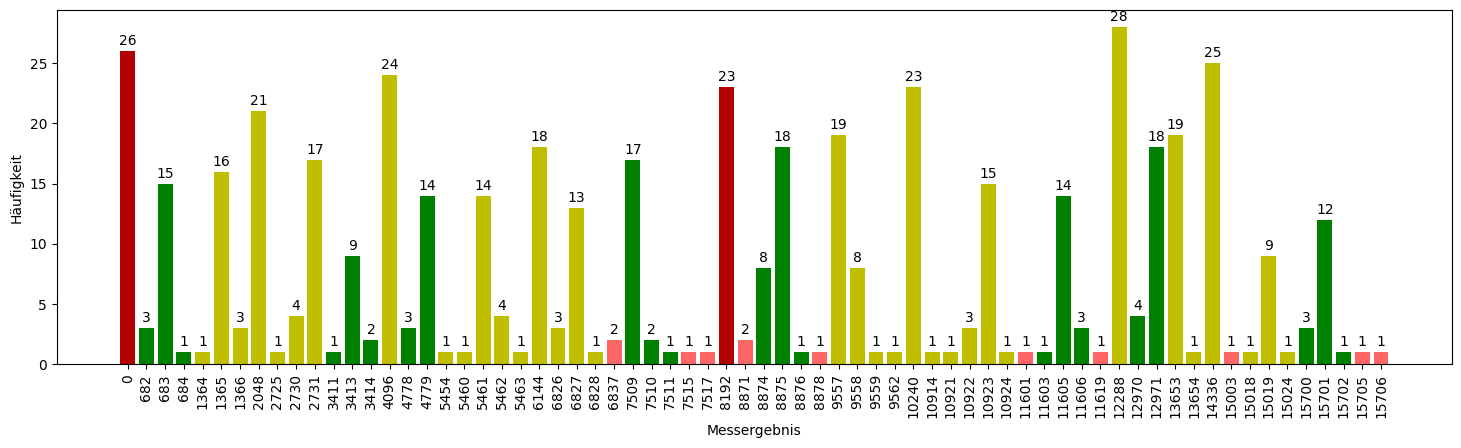

In [39]:
data_dict = binary_to_decimal_in_dict_print(yyy, 14, 119)
hellrot = (1, 0.4, 0.4)  # RGB für Hellrot
dunkelrot = (0.7, 0, 0) 

states = list(data_dict.keys())
counts = [value[0] for value in data_dict.values()]

# Zusätzliche Bedingungen für die Farben
colors = ['g' if value[1] == 24 else 'y' if value[1] == 6 or value[1] == 8 or value[1] == 4 or value[1] == 12 or value[1] == 3 else (0.7, 0, 0) if value[0] == 26 or value[0] == 23 else (1, 0.4, 0.4) for value in data_dict.values()]

plt.figure(figsize=(18, 4.6))

for i, (state, count, color) in enumerate(zip(states, counts, colors)):
    plt.bar(i, count, color=color)
    
    # Text über jedem Balken mit Abstand
    plt.text(i, count + 0.5, str(count), ha='center')  # 0.5 ist der Abstand zum Balken

plt.xlabel("Messergebnis")
plt.ylabel("Häufigkeit")
plt.xticks(ticks=range(len(states)), labels=states, rotation=90)

# Entfernt die Legende
plt.gca().legend_ = None

plt.show()

In [19]:
import matplotlib.pyplot as plt

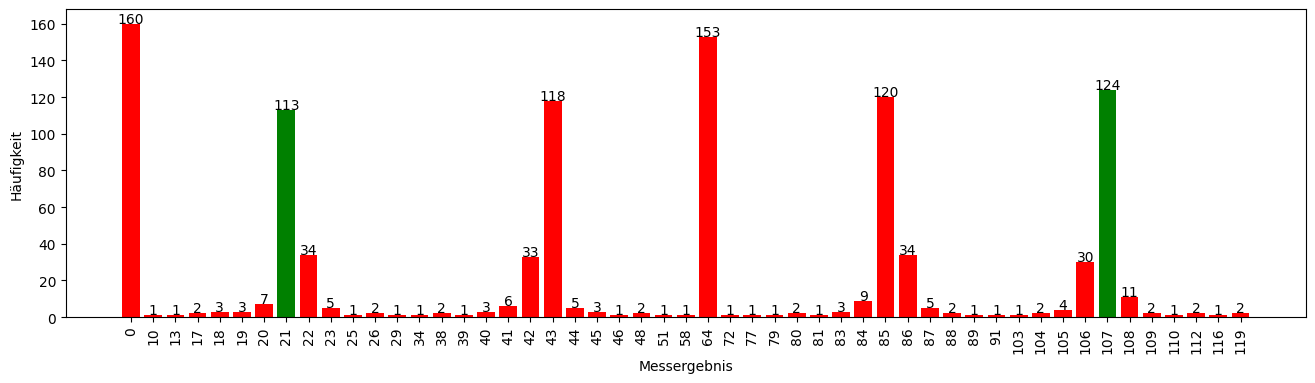

In [26]:
data_dict = binary_to_decimal_in_dict_print(y, 7, 21)

states = list(data_dict.keys())
counts = [value[0] for value in data_dict.values()]

# Zusätzliche Bedingungen für die Farben
colors = ['g' if value[1] == 6 else 'r' for value in data_dict.values()]

plt.figure(figsize=(16, 4))

for i, (state, count, color) in enumerate(zip(states, counts, colors)):
    plt.bar(i, count, color=color)
    
    # Text über jedem Balken mit Abstand
    plt.text(i, count + 0.5, str(count), ha='center')  # 0.5 ist der Abstand zum Balken

plt.xlabel("Messergebnis")
plt.ylabel("Häufigkeit")
plt.xticks(ticks=range(len(states)), labels=states, rotation=90)

# Entfernt die Legende
plt.gca().legend_ = None

plt.show()

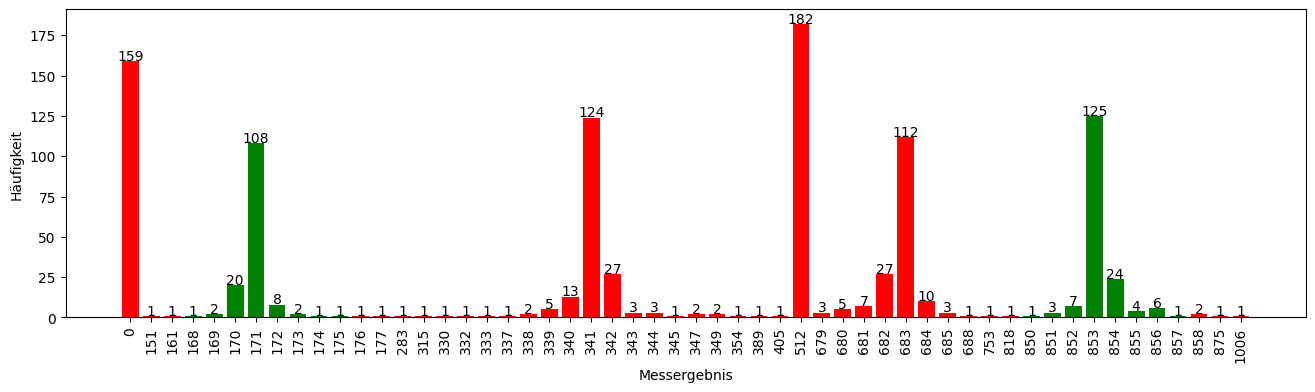

In [25]:
data_dict = binary_to_decimal_in_dict_print(yx, 10, 21)

states = list(data_dict.keys())
counts = [value[0] for value in data_dict.values()]

# Zusätzliche Bedingungen für die Farben
colors = ['g' if value[1] == 6 else 'r' for value in data_dict.values()]

plt.figure(figsize=(16, 4))

for i, (state, count, color) in enumerate(zip(states, counts, colors)):
    plt.bar(i, count, color=color)
    
    # Text über jedem Balken mit Abstand
    plt.text(i, count + 0.5, str(count), ha='center')  # 0.5 ist der Abstand zum Balken

plt.xlabel("Messergebnis")
plt.ylabel("Häufigkeit")
plt.xticks(ticks=range(len(states)), labels=states, rotation=90)

# Entfernt die Legende
plt.gca().legend_ = None

plt.show()

In [33]:
def Faktorisierungsalgorithmus(N: int) -> list[int,int]:
    neightbore_range = 2**math.ceil(math.log2(N.bit_length()))
    k = 2*N.bit_length()
    while True:
        print("Round")
        a = randint(2, N-1)
        if math.gcd(a, N) != 1:
            print("No Quantum")
            return [math.gcd(a, N), N//math.gcd(a, N)] #Zufällig Faktoren gefunden
        measured_fracs = set()
        while True:
            print("new shor")
            Measuring = int(list(Shor_sequential_test(a, N))[0], 2)
            fracMeasuring = fracPeriod(Measuring,N, k)
            print(a)
            print(fracMeasuring)
            if not isPeriod(a, fracMeasuring.denominator, N):
                print("Check Multiple")
                if isInMultiplePeriod(a, fracMeasuring, N,neightbore_range):
                    break
                print("Check kgv")
                if isInLeastCommonMultiplePeriod(a,fracMeasuring,N, k, measured_fracs):
                    break
                print("Check neigbors")
                if hasNeightborePeriod(a,Measuring,N, k, measured_fracs,neightbore_range):
                    break
                measured_fracs.add(fracMeasuring)
                print(measured_fracs)
                continue
            break
        if not passCriteria(a, fracMeasuring, N):
            continue
        factors = calcFactors(a,fracMeasuring, N)
        if not nonTrivialFactor(factors, N):
            continue
        return factors
        
        

In [34]:
def fracPeriod(measuring: int,N: int, k: int) -> int:
    return Fraction(measuring/2**k).limit_denominator(N)

In [35]:
def isPeriod(a: int, denominator: int, N: int) -> bool:
    return mod_exp(a, denominator, N) == 1

In [36]:
def passCriteria(a: int, fracMeasuring: Fraction, N: int) -> bool:
    return fracMeasuring.denominator%2==0 and mod_exp(a,fracMeasuring.denominator//2, N) != N-1

In [37]:
def calcFactors(a: int, fracMeasuring: Fraction, N: int) -> list[int,int]:
    return [math.gcd(a**(fracMeasuring.denominator//2)-1, N),math.gcd(a**(fracMeasuring.denominator//2)+1, N)]

In [38]:
def nonTrivialFactor(factors: list, N : int) -> bool:
    return not ((factors[0] == 1 or factors[0] == N) and (factors[1] == 1 or factors[1] == N))

In [39]:
def isInMultiplePeriod(a, fracMeasuring, N,neightbore_range) -> bool:
    for i in range(2,neightbore_range):
        if isPeriod(a, fracMeasuring.denominator*i, N):
            fracMeasuring = Fraction(1, fracMeasuring.denominator*i)
            return True
    return False

In [40]:
def isInLeastCommonMultiplePeriod(a,measuring,N, k, measured_fracs) -> bool:
    for frac in measured_fracs:
        print("kgv:" + str(measuring.denominator) + " " + str(frac.denominator))
        print(kgV(measuring.denominator, frac.denominator))
        if isPeriod(a, kgV(measuring.denominator, frac.denominator), N):
            fracMeasuring = Fraction(1, kgV(measuring.denominator, frac.denominator))
            print("periodic")
            return True
    return False

In [41]:
def hasNeightborePeriod(a,measuring,N, k, measured_fracs,neightbore_range) -> bool:
    for i in range(1,neightbore_range):
        if(measuring+i < 2**k and isPeriod(a,fracPeriod(measuring+i, N, k).denominator,N)):
            measured_fracs = Fraction(1, fracPeriod(measuring+i, N, k).denominator)
            return True
        elif (measuring-i > 0 and isPeriod(a,fracPeriod(measuring-i, N, k).denominator,N)):
            measured_fracs = Fraction(1, fracPeriod(measuring-i, N, k).denominator)
            return True
    return False
            
    

In [29]:
print(Faktorisierungsalgorithmus(629))

Round
new shor
552
13/18
Check Multiple
[37, 1]


In [42]:
print(Faktorisierungsalgorithmus(713))

Round
new shor
595
9/22
Check Multiple
[1, 23]


In [16]:
print(548**(36)%629)

1


In [78]:
print(31**15%77)

34


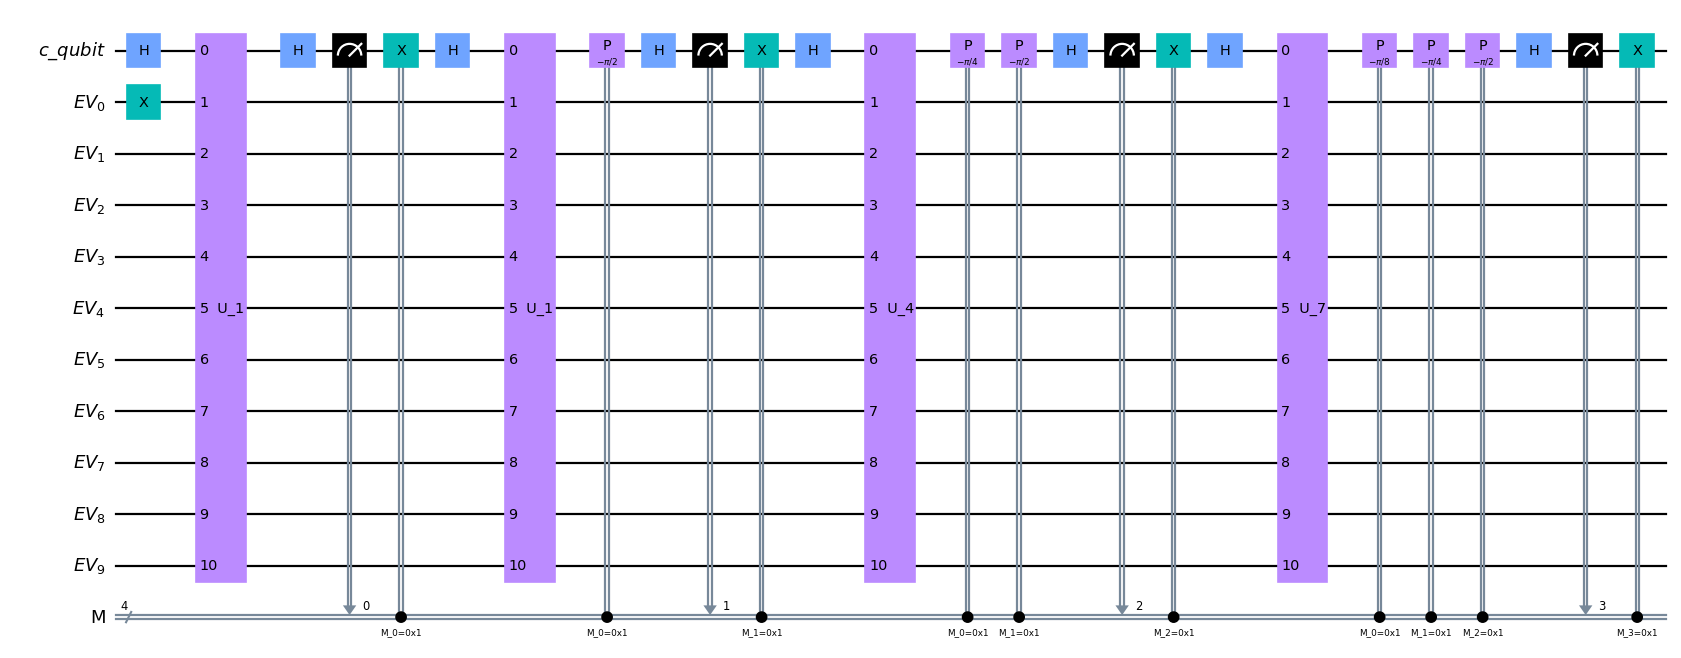

In [27]:
a=7
N=15
n = N.bit_length()
k = n
c_qbits = range(k)
controlling_qubit = qiskit.QuantumRegister(1, "c_qubit")
qreg = qiskit.QuantumRegister(2*n+2, "EV")
creg = qiskit.ClassicalRegister(len(c_qbits), "M")
qc = qiskit.QuantumCircuit(controlling_qubit, qreg,creg) 
qc.x(1)
for control in c_qbits:
    qc.h(0)
    qc.append(U_gate(n,dezToBin(mod_exp(a, 2**(len(c_qbits) - control - 1), N),n+1),dezToBin(N,n+1)),[0] + list(range(1,2*n+3)))
    R_gate(control,qc,creg,controlling_qubit)
    qc.measure(controlling_qubit,creg[control])
    qc.x(0).c_if(creg[control],1)
qc.draw(output='mpl',fold  = 270,scale=0.8)


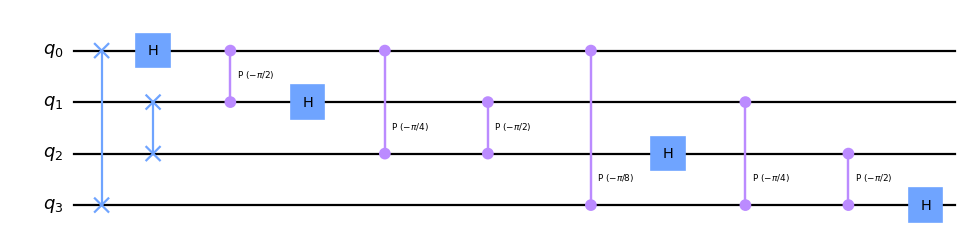

In [32]:

qc = QFT_Gate(4,inverse = True, MSB_first = False,swaps = True)
qc.draw(output='mpl',fold  = 270,scale=0.8)